# Model for audio data

Ensure the following requirements are ready: 

```
numpy==1.23.5
torch==2.0.0+cu118
matplotlib==3.7.1
pillow==10.2.0
timm==0.3.2
```

Then `git clone https://github.com/facebookresearch/mae.git`

Run this notebook within `mae/` folder

# Utility functions

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd 
# from MAE code
from util.datasets import build_dataset
import argparse
import util.misc as misc
import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter

import timm

assert timm.__version__ == "0.3.2" # version check
from timm.models.layers import trunc_normal_
from timm.data.mixup import Mixup
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy

import util.lr_decay as lrd
import util.misc as misc
from util.datasets import build_dataset
from util.pos_embed import interpolate_pos_embed
from util.misc import NativeScalerWithGradNormCount as NativeScaler

import models_vit
import sys
import os
import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import models_mae
import torch; print(f'numpy version: {np.__version__}\nCUDA version: {torch.version.cuda} - Torch versteion: {torch.__version__} - device count: {torch.cuda.device_count()}')

from engine_finetune import train_one_epoch, evaluate
from timm.data import Mixup
from timm.utils import accuracy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()
# Set the seed for PyTorch
torch.manual_seed(42)

/home/sebastian/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-02-12 00:12:14.036642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 00:12:14.036676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 00:12:14.037869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 00:12:14.043401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU in

numpy version: 1.23.5
CUDA version: 11.8 - Torch versteion: 2.0.0+cu118 - device count: 2


# Parametrize model

In [3]:
parser = argparse.ArgumentParser('MAE fine-tuning for image classification', add_help=False)
parser.add_argument('--batch_size', default=32, type=int,
                        help='Batch size per GPU (effective batch size is batch_size * accum_iter * # gpus')
parser.add_argument('--epochs', default=100, type=int)
parser.add_argument('--accum_iter', default=4, type=int,
                        help='Accumulate gradient iterations (for increasing the effective batch size under memory constraints)')

    # Model parameters
parser.add_argument('--model', default='vit_base_patch16', type=str, metavar='MODEL',
                        help='Name of model to train')

parser.add_argument('--input_size', default=224, type=int,
                        help='images input size')

parser.add_argument('--drop_path', type=float, default=0.1, metavar='PCT',
                        help='Drop path rate (default: 0.1)')

    # Optimizer parameters
parser.add_argument('--clip_grad', type=float, default=None, metavar='NORM',
                        help='Clip gradient norm (default: None, no clipping)')
parser.add_argument('--weight_decay', type=float, default=0.05,
                        help='weight decay (default: 0.05)')

parser.add_argument('--lr', type=float, default=None, metavar='LR',
                        help='learning rate (absolute lr)')
parser.add_argument('--blr', type=float, default=5e-4, metavar='LR',
                        help='base learning rate: absolute_lr = base_lr * total_batch_size / 256')
parser.add_argument('--layer_decay', type=float, default=0.65,
                        help='layer-wise lr decay from ELECTRA/BEiT')

parser.add_argument('--min_lr', type=float, default=1e-6, metavar='LR',
                        help='lower lr bound for cyclic schedulers that hit 0')

parser.add_argument('--warmup_epochs', type=int, default=5, metavar='N',
                        help='epochs to warmup LR')

    # Augmentation parameters
parser.add_argument('--color_jitter', type=float, default=None, metavar='PCT',
                        help='Color jitter factor (enabled only when not using Auto/RandAug)')
parser.add_argument('--aa', type=str, default='rand-m9-mstd0.5-inc1', metavar='NAME',
                        help='Use AutoAugment policy. "v0" or "original". " + "(default: rand-m9-mstd0.5-inc1)'),
parser.add_argument('--smoothing', type=float, default=0.1,
                        help='Label smoothing (default: 0.1)')

    # * Random Erase params
parser.add_argument('--reprob', type=float, default=0.25, metavar='PCT',
                        help='Random erase prob (default: 0.25)')
parser.add_argument('--remode', type=str, default='pixel',
                        help='Random erase mode (default: "pixel")')
parser.add_argument('--recount', type=int, default=1,
                        help='Random erase count (default: 1)')
parser.add_argument('--resplit', action='store_true', default=False,
                        help='Do not random erase first (clean) augmentation split')
    # * Mixup params
parser.add_argument('--mixup', type=float, default=0.8,
                        help='mixup alpha, mixup enabled if > 0.')
parser.add_argument('--cutmix', type=float, default=1.0,
                        help='cutmix alpha, cutmix enabled if > 0.')
parser.add_argument('--cutmix_minmax', type=float, nargs='+', default=None,
                        help='cutmix min/max ratio, overrides alpha and enables cutmix if set (default: None)')
parser.add_argument('--mixup_prob', type=float, default=1.0,
                        help='Probability of performing mixup or cutmix when either/both is enabled')
parser.add_argument('--mixup_switch_prob', type=float, default=0.5,
                        help='Probability of switching to cutmix when both mixup and cutmix enabled')

parser.add_argument('--mixup_mode', type=str, default='batch',
                        help='How to apply mixup/cutmix params. Per "batch", "pair", or "elem"')

    # * Finetuning params
parser.add_argument('--finetune', default='mae_pretrain_vit_base.pth',
                        help='finetune from checkpoint')
parser.add_argument('--global_pool', action='store_true')
parser.set_defaults(global_pool=True)
parser.add_argument('--cls_token', action='store_false', dest='global_pool',
                        help='Use class token instead of global pool for classification')

    # Dataset parameters
parser.add_argument('--data_path', default='/media/enc/vera1/sebastian/data/Datos_Entrenamiento/', type=str,
                        help='dataset path')
parser.add_argument('--nb_classes', default=7, type=int,
                        help='number of the classification types')

parser.add_argument('--output_dir', default='EXP_base_biggest_dataset',
                        help='path where to save, empty for no saving')
parser.add_argument('--log_dir', default='./output_dir',
                        help='path where to tensorboard log')
parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
parser.add_argument('--seed', default=0, type=int)
parser.add_argument('--resume', default='./EXP_base_biggest_dataset/checkpoint-99.pth',
                        help='resume from checkpoint')

parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
parser.add_argument('--eval',default=True, action='store_true',
                        help='Perform evaluation only')
parser.add_argument('--dist_eval', action='store_true', default=False,
                        help='Enabling distributed evaluation (recommended during training for faster monitor')
parser.add_argument('--num_workers', default=10, type=int)
parser.add_argument('--pin_mem', action='store_true',
                        help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
parser.add_argument('--no_pin_mem', action='store_false', dest='pin_mem')
parser.set_defaults(pin_mem=True)

    # distributed training parameters
parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
parser.add_argument('--local_rank', default=-1, type=int)
parser.add_argument('--dist_on_itp', action='store_true')
parser.add_argument('--dist_url', default='env://',
                        help='url used to set up distributed training')
args, unknown = parser.parse_known_args()
misc.init_distributed_mode(args)
print("{}".format(args).replace(', ', ',\n'))

device = torch.device(args.device)

Not using distributed mode
[00:12:15.176556] Namespace(batch_size=32,
epochs=100,
accum_iter=4,
model='vit_base_patch16',
input_size=224,
drop_path=0.1,
clip_grad=None,
weight_decay=0.05,
lr=None,
blr=0.0005,
layer_decay=0.65,
min_lr=1e-06,
warmup_epochs=5,
color_jitter=None,
aa='rand-m9-mstd0.5-inc1',
smoothing=0.1,
reprob=0.25,
remode='pixel',
recount=1,
resplit=False,
mixup=0.8,
cutmix=1.0,
cutmix_minmax=None,
mixup_prob=1.0,
mixup_switch_prob=0.5,
mixup_mode='batch',
finetune='mae_pretrain_vit_base.pth',
global_pool=True,
data_path='/media/enc/vera1/sebastian/data/Datos_Entrenamiento/',
nb_classes=7,
output_dir='EXP_base_biggest_dataset',
log_dir='./output_dir',
device='cuda',
seed=0,
resume='./EXP_base_biggest_dataset/checkpoint-99.pth',
start_epoch=0,
eval=True,
dist_eval=False,
num_workers=10,
pin_mem=True,
world_size=1,
local_rank=-1,
dist_on_itp=False,
dist_url='env://',
distributed=False)


since pytorch > 1.8, then have to update this i ~/anaconda3/lib/python3.11/site-packages/timm/models/layers/helpers.py with https://github.com/huggingface/pytorch-image-models/issues/420 

In [4]:
    misc.init_distributed_mode(args)

    # print('job dir: {}'.format(os.path.dirname(os.path.realpath(__file__))))
    print("{}".format(args).replace(', ', ',\n'))

    device = torch.device(args.device)

    # fix the seed for reproducibility
    seed = args.seed + misc.get_rank()
    torch.manual_seed(seed)
    np.random.seed(seed)

    cudnn.benchmark = True

    dataset_train = build_dataset(is_train=True, args=args)
    dataset_val = build_dataset(is_train=False, args=args)

    if True:  # args.distributed:
        num_tasks = misc.get_world_size()
        global_rank = misc.get_rank()
        sampler_train = torch.utils.data.DistributedSampler(
            dataset_train, num_replicas=num_tasks, rank=global_rank, shuffle=True
        )
        print("Sampler_train = %s" % str(sampler_train))
        if args.dist_eval:
            if len(dataset_val) % num_tasks != 0:
                print('Warning: Enabling distributed evaluation with an eval dataset not divisible by process number. '
                      'This will slightly alter validation results as extra duplicate entries are added to achieve '
                      'equal num of samples per-process.')
            sampler_val = torch.utils.data.DistributedSampler(
                dataset_val, num_replicas=num_tasks, rank=global_rank, shuffle=True)  # shuffle=True to reduce monitor bias
        else:
            sampler_val = torch.utils.data.SequentialSampler(dataset_val)
    else:
        sampler_train = torch.utils.data.RandomSampler(dataset_train)
        sampler_val = torch.utils.data.SequentialSampler(dataset_val)

    if global_rank == 0 and args.log_dir is not None and not args.eval:
        os.makedirs(args.log_dir, exist_ok=True)
        log_writer = SummaryWriter(log_dir=args.log_dir)
    else:
        log_writer = None

    data_loader_train = torch.utils.data.DataLoader(
        dataset_train, sampler=sampler_train,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=True,
    )

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, sampler=sampler_val,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=False
    )

[00:12:23.401554] Not using distributed mode
[00:12:23.401639] [00:12:23.401636] [00:12:23.401647] Namespace(batch_size=32,
epochs=100,
accum_iter=4,
model='vit_base_patch16',
input_size=224,
drop_path=0.1,
clip_grad=None,
weight_decay=0.05,
lr=None,
blr=0.0005,
layer_decay=0.65,
min_lr=1e-06,
warmup_epochs=5,
color_jitter=None,
aa='rand-m9-mstd0.5-inc1',
smoothing=0.1,
reprob=0.25,
remode='pixel',
recount=1,
resplit=False,
mixup=0.8,
cutmix=1.0,
cutmix_minmax=None,
mixup_prob=1.0,
mixup_switch_prob=0.5,
mixup_mode='batch',
finetune='mae_pretrain_vit_base.pth',
global_pool=True,
data_path='/media/enc/vera1/sebastian/data/Datos_Entrenamiento/',
nb_classes=7,
output_dir='EXP_base_biggest_dataset',
log_dir='./output_dir',
device='cuda',
seed=0,
resume='./EXP_base_biggest_dataset/checkpoint-99.pth',
start_epoch=0,
eval=True,
dist_eval=False,
num_workers=10,
pin_mem=True,
world_size=1,
local_rank=-1,
dist_on_itp=False,
dist_url='env://',
distributed=False)
[00:12:23.417785] [00:12:23.417779

In [4]:
# #Liberia Validacion cruzada
# from sklearn.model_selection import KFold
# # K-fold cross-validation
# num_splits = 5  # ajusta el número de splits según tus necesidades
# kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

# for fold, (train_index, val_index) in enumerate(kf.split(dataset_train)):
#     print(f"\nTraining on Fold {fold + 1}/{num_splits}:")

#     # create train and validation sets for this fold
#     train_dataset_fold = Subset(dataset_train, train_index)
#     val_dataset_fold = Subset(dataset_train, val_index)

#     data_loader_train = torch.utils.data.DataLoader(
#         train_dataset_fold, sampler=torch.utils.data.RandomSampler(train_dataset_fold),
#         batch_size=args.batch_size,
#         num_workers=args.num_workers,
#         pin_memory=args.pin_mem,
#         drop_last=True,
#     )

#     data_loader_val = torch.utils.data.DataLoader(
#         val_dataset_fold, sampler=torch.utils.data.SequentialSampler(val_dataset_fold),
#         batch_size=args.batch_size,
#         num_workers=args.num_workers,
#         pin_memory=args.pin_mem,
#         drop_last=False
#     )

In [5]:
    mixup_fn = None
    mixup_active = args.mixup > 0 or args.cutmix > 0. or args.cutmix_minmax is not None
    if mixup_active:
        print("Mixup is activated!")
        mixup_fn = Mixup(
            mixup_alpha=args.mixup, cutmix_alpha=args.cutmix, cutmix_minmax=args.cutmix_minmax,
            prob=args.mixup_prob, switch_prob=args.mixup_switch_prob, mode=args.mixup_mode,
            label_smoothing=args.smoothing, num_classes=args.nb_classes)
    
    model = models_vit.__dict__[args.model](
        num_classes=args.nb_classes,
        drop_path_rate=args.drop_path,
        global_pool=args.global_pool,
    )

    if args.finetune and not args.eval:
        checkpoint = torch.load(args.finetune, map_location='cpu')

        print("Load pre-trained checkpoint from: %s" % args.finetune)
        checkpoint_model = checkpoint['model']
        state_dict = model.state_dict()
        for k in ['head.weight', 'head.bias']:
            if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
                print(f"Removing key {k} from pretrained checkpoint")
                del checkpoint_model[k]

        # interpolate position embedding
        interpolate_pos_embed(model, checkpoint_model)

        # load pre-trained model
        msg = model.load_state_dict(checkpoint_model, strict=False)
        print(msg)

        if args.global_pool:
            assert set(msg.missing_keys) == {'head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'}
        else:
            assert set(msg.missing_keys) == {'head.weight', 'head.bias'}

        # manually initialize fc layer
        trunc_normal_(model.head.weight, std=2e-5)

    model.to(device)

    model_without_ddp = model
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("Model = %s" % str(model_without_ddp))
    print('number of params (M): %.2f' % (n_parameters / 1.e6))

    eff_batch_size = args.batch_size * args.accum_iter * misc.get_world_size()
    
    if args.lr is None:  # only base_lr is specified
        args.lr = args.blr * eff_batch_size / 256

    print("base lr: %.2e" % (args.lr * 256 / eff_batch_size))
    print("actual lr: %.2e" % args.lr)

    print("accumulate grad iterations: %d" % args.accum_iter)
    print("effective batch size: %d" % eff_batch_size)

    if args.distributed:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
        model_without_ddp = model.module

    # build optimizer with layer-wise lr decay (lrd)
    param_groups = lrd.param_groups_lrd(model_without_ddp, args.weight_decay,
        no_weight_decay_list=model_without_ddp.no_weight_decay(),
        layer_decay=args.layer_decay
    )
    optimizer = torch.optim.AdamW(param_groups, lr=args.lr)
    loss_scaler = NativeScaler()

    if mixup_fn is not None:
        # smoothing is handled with mixup label transform
        criterion = SoftTargetCrossEntropy()
    elif args.smoothing > 0.:
        criterion = LabelSmoothingCrossEntropy(smoothing=args.smoothing)
    else:
        criterion = torch.nn.CrossEntropyLoss()

    print("criterion = %s" % str(criterion))

    misc.load_model(args=args, model_without_ddp=model_without_ddp, optimizer=optimizer, loss_scaler=loss_scaler)

    if args.eval:
        test_stats = evaluate(data_loader_val, model, device)
        print(f"Accuracy of the network on the {len(dataset_val)} test images: {test_stats['acc1']:.1f}%")
        # exit(0)


[00:12:35.113184] [00:12:35.113168] [00:12:35.113233] Mixup is activated!
[00:12:35.993222] [00:12:35.993211] [00:12:35.993276] Model = VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p

# Train model
Run a conda environment or alternatively just run the cell below

### Base model
Finetuning using the base vit pretrained model  which is downloaded from here (https://github.com/facebookresearch/mae?tab=readme-ov-file#fine-tuning-with-pre-trained-checkpoints). The way to find the correct finetunng is explaned here (https://github.com/facebookresearch/mae/issues?q=is%3Aissue+is%3Aopen+classes )

`python main_finetune.py --accum_iter 4 --batch_size 32 --model vit_base_patch16 --finetune mae_pretrain_vit_base.pth --epochs 100 --blr 5e-4 --layer_decay 0.65 --weight_decay 0.05 --drop_path 0.1 --mixup 0.8 --cutmix 1.0 --reprob 0.25 --dist_eval --data_path /media/enc/vera1/sebastian/data/Data-set-Urban_Esc/ --nb_classes 7`

Expected results: 

```
[04:05:12.377034] * Acc@1 83.388 Acc@5 99.836 loss 0.572
[04:05:12.377152] Accuracy of the network on the 608 test images: 83.4%
[04:05:12.377165] Max accuracy: 83.55%
[04:05:12.378265] Training time 0:46:57
```

### Large model

`python main_finetune.py --accum_iter 4 --batch_size 16 --model vit_large_patch16 --finetune mae_pretrain_vit_large.pth --epochs 100 --blr 5e-4 --layer_decay 0.65 --weight_decay 0.05 --drop_path 0.1 --mixup 0.8 --cutmix 1.0 --reprob 0.25 --dist_eval --data_path /media/enc/vera1/sebastian/data/Data-set-Urban_Esc/ --nb_classes 7 --output_dir EXP_large_vit`

Expected results: 

```
[06:10:18.181183] Test: Total time: 0:00:04 (0.1237 s / it)
[06:10:18.181592] * Acc@1 83.059 Acc@5 99.671 loss 0.586
[06:10:18.181741] Accuracy of the network on the 608 test images: 83.1%
[06:10:18.181759] Max accuracy: 83.06%
[06:10:18.182753] Training time 1:18:19
```



In [6]:
train = False

if train:
    print(f"Start training for {args.epochs} epochs")
    start_time = time.time()
    max_accuracy = 0.0
    
    for epoch in range(args.start_epoch, args.epochs):
        if args.distributed:
            data_loader_train.sampler.set_epoch(epoch)
        train_stats = train_one_epoch(
            model, criterion, data_loader_train,
            optimizer, device, epoch, loss_scaler,
            args.clip_grad, mixup_fn,
            log_writer=log_writer,
            args=args
        )
        if args.output_dir:
            misc.save_model(
                args=args, model=model, model_without_ddp=model_without_ddp, optimizer=optimizer,
                loss_scaler=loss_scaler, epoch=epoch)

        test_stats = evaluate(data_loader_val, model, device)
        print(f"Accuracy of the network on the {len(dataset_val)} test images: {test_stats['acc1']:.1f}%")
        max_accuracy = max(max_accuracy, test_stats["acc1"])
        print(f'Max accuracy: {max_accuracy:.2f}%')

        if log_writer is not None:
            log_writer.add_scalar('perf/test_acc1', test_stats['acc1'], epoch)
            log_writer.add_scalar('perf/test_acc5', test_stats['acc5'], epoch)
            log_writer.add_scalar('perf/test_loss', test_stats['loss'], epoch)

        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                        **{f'test_{k}': v for k, v in test_stats.items()},
                        'epoch': epoch,
                        'n_parameters': n_parameters}

        if args.output_dir and misc.is_main_process():
            if log_writer is not None:
                log_writer.flush()
            with open(os.path.join(args.output_dir, "log.txt"), mode="a", encoding="utf-8") as f:
                f.write(json.dumps(log_stats) + "\n")

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))

# Evaluate loaded model

In [8]:
EXPERIMENT_NAME = "eval_vit_base_large_dataset"

saving_model = f"{EXPERIMENT_NAME}/models"
os.makedirs(saving_model, exist_ok = True)
os.makedirs(EXPERIMENT_NAME, exist_ok=True)

In [9]:
if args.eval:
        test_stats = evaluate(data_loader_val, model, device)
        print(f"Accuracy of the network on the {len(dataset_val)} test images: {test_stats['acc1']:.1f}%")
        

[00:13:25.067493] [00:13:25.067479] [00:13:25.067627] Test:  [ 0/68]  eta: 0:01:57  loss: 0.2413 (0.2413)  acc1: 96.8750 (96.8750)  acc5: 100.0000 (100.0000)  time: 1.7270  data: 1.7034  max mem: 688
[00:13:26.425387] [00:13:26.425378] [00:13:26.425450] Test:  [10/68]  eta: 0:00:16  loss: 0.2689 (0.4229)  acc1: 93.7500 (89.4886)  acc5: 100.0000 (99.1477)  time: 0.2804  data: 0.2634  max mem: 688
[00:13:27.812184] [00:13:27.812174] [00:13:27.812243] Test:  [20/68]  eta: 0:00:10  loss: 0.2131 (0.3191)  acc1: 96.8750 (93.3036)  acc5: 100.0000 (99.5536)  time: 0.1372  data: 0.1208  max mem: 688
[00:13:29.205351] [00:13:29.205340] [00:13:29.205415] Test:  [30/68]  eta: 0:00:07  loss: 0.2131 (0.3804)  acc1: 93.7500 (91.5323)  acc5: 100.0000 (99.3952)  time: 0.1389  data: 0.1228  max mem: 688
[00:13:30.610406] [00:13:30.610396] [00:13:30.610465] Test:  [40/68]  eta: 0:00:04  loss: 0.3221 (0.3717)  acc1: 93.7500 (91.8445)  acc5: 100.0000 (99.4665)  time: 0.1398  data: 0.1239  max mem: 688
[00:

In [10]:
@torch.no_grad()
def evaluate_test(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()

    metric_logger = misc.MetricLogger(delimiter="  ")
    header = 'Test:'

    # switch to evaluation mode
    model.eval()
    all_predictions = []
    all_labels = []

    for batch in metric_logger.log_every(data_loader, 10, header):
        images = batch[0]
        target = batch[-1]
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)            
            loss = criterion(output, target)#
            pred = output.argmax(dim=1) 
        all_predictions.append(pred.cpu().numpy())# ADDED
        all_labels.append(target.cpu().numpy())# ADDED
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        
        batch_size = images.shape[0]
        metric_logger.update(loss=loss.item())
        metric_logger.meters['acc1'].update(acc1.item(), n=batch_size)
        metric_logger.meters['acc5'].update(acc5.item(), n=batch_size)
    
    all_predictions = np.array(all_predictions)#.squeeze(0)
    all_labels = np.array(all_labels)#.squeeze(0)
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print('* Acc@1 {top1.global_avg:.3f} Acc@5 {top5.global_avg:.3f} loss {losses.global_avg:.3f}'
          .format(top1=metric_logger.acc1, top5=metric_logger.acc5, losses=metric_logger.loss))

    # return 

    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}, np.concatenate(all_predictions, axis=0), np.concatenate(all_labels, axis=0)
    

metrics, all_predictions, all_labels = evaluate_test(data_loader_val, model, device)
# print(f"Accuracy of the network on the {len(dataset_val)} test images: {test_stats['acc1']:.1f}%")


[00:13:35.235712] [00:13:35.235699] [00:13:35.235886] Test:  [ 0/68]  eta: 0:01:55  loss: 0.2413 (0.2413)  acc1: 96.8750 (96.8750)  acc5: 100.0000 (100.0000)  time: 1.6930  data: 1.6760  max mem: 688
[00:13:36.606077] [00:13:36.606067] [00:13:36.606137] Test:  [10/68]  eta: 0:00:16  loss: 0.2689 (0.4229)  acc1: 93.7500 (89.4886)  acc5: 100.0000 (99.1477)  time: 0.2784  data: 0.2623  max mem: 688
[00:13:38.002488] [00:13:38.002478] [00:13:38.002540] Test:  [20/68]  eta: 0:00:10  loss: 0.2131 (0.3191)  acc1: 96.8750 (93.3036)  acc5: 100.0000 (99.5536)  time: 0.1383  data: 0.1222  max mem: 688
[00:13:39.388163] [00:13:39.388153] [00:13:39.388212] Test:  [30/68]  eta: 0:00:07  loss: 0.2131 (0.3804)  acc1: 93.7500 (91.5323)  acc5: 100.0000 (99.3952)  time: 0.1390  data: 0.1230  max mem: 688
[00:13:40.777662] [00:13:40.777652] [00:13:40.777715] Test:  [40/68]  eta: 0:00:04  loss: 0.3221 (0.3717)  acc1: 93.7500 (91.8445)  acc5: 100.0000 (99.4665)  time: 0.1387  data: 0.1226  max mem: 688
[00:

/tmp/ipykernel_1361436/3368932055.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_predictions = np.array(all_predictions)#.squeeze(0)
/tmp/ipykernel_1361436/3368932055.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_labels = np.array(all_labels)#.squeeze(0)


In [11]:
metrics

{'loss': 0.38848381182726693,
 'acc1': 90.81679742326371,
 'acc5': 99.67697277341948}

In [12]:
all_predictions

array([0, 0, 0, ..., 5, 3, 5])

In [13]:
unique_classes = np.unique(np.concatenate((all_labels, all_predictions)))
unique_classes

array([0, 1, 2, 3, 4, 5, 6])

In [14]:
confusion_mat = confusion_matrix(all_labels, all_predictions, labels=unique_classes)
conf_matrix = pd.DataFrame(confusion_mat, index=unique_classes, columns=unique_classes)
conf_matrix

,0,1,2,3,4,5,6
0,229,6,2,6,1,5,13
1,3,495,0,0,1,8,2
2,3,3,71,3,0,3,2
3,2,3,7,151,0,10,16
4,3,0,0,1,170,0,2
5,3,7,2,10,4,419,3
6,6,3,1,36,1,18,433


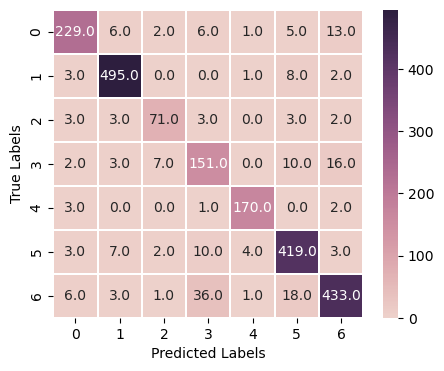

In [15]:
unique_classes = np.unique(np.concatenate((all_labels, all_predictions)))
confusion_mat = confusion_matrix(all_labels, all_predictions, labels=unique_classes)
conf_matrix = pd.DataFrame(confusion_mat, index=unique_classes, columns=unique_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(5, 4))
ax = sns.heatmap(conf_matrix, annot=True,  fmt='.1f', cmap=sns.cubehelix_palette(as_cmap=True), linewidths=0.1, cbar=True)

# Set labels and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# Set x and y ticks using the unique classes
ax.set_xticks(range(len(unique_classes)))
ax.set_yticks(range(len(unique_classes)))

# Set x and y ticks at the center of the cells
ax.set_xticks([i + 0.5 for i in range(len(unique_classes))])
ax.set_yticks([i + 0.5 for i in range(len(unique_classes))])

plt.show()

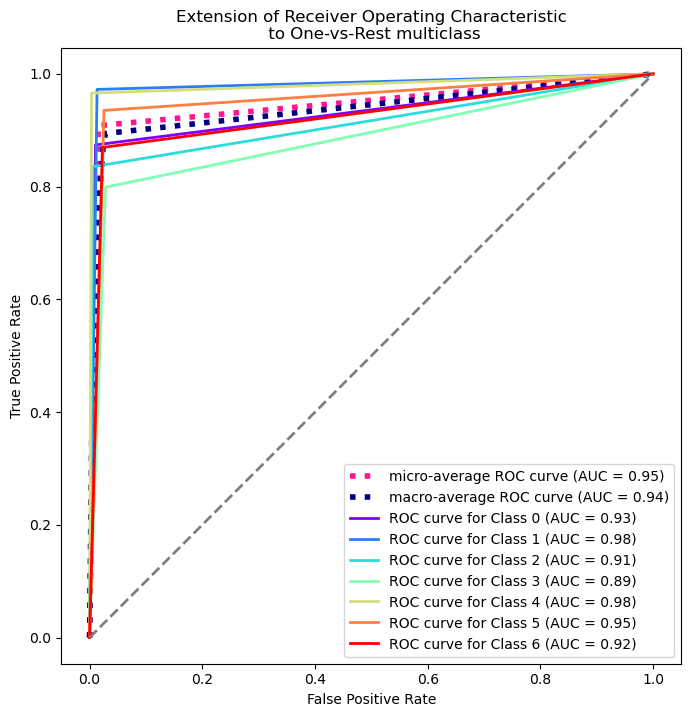

In [16]:
def plot_multiclass_roc_curve(all_labels, all_predictions, EXPERIMENT_NAME="."):
    # Step 1: Label Binarization
    label_binarizer = LabelBinarizer()
    y_onehot = label_binarizer.fit_transform(all_labels)
    all_predictions_hot = label_binarizer.transform(all_predictions)

    # Step 2: Calculate ROC curves
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    unique_classes = range(y_onehot.shape[1])
    for i in unique_classes:
        fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], all_predictions_hot[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Step 3: Plot ROC curves
    fig, ax = plt.subplots(figsize=(8, 8))

    # Micro-average ROC curve
    fpr_micro, tpr_micro, _ = roc_curve(y_onehot.ravel(), all_predictions_hot.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(
        fpr_micro,
        tpr_micro,
        label=f"micro-average ROC curve (AUC = {roc_auc_micro:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    # Macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in unique_classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in unique_classes:
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(unique_classes)
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    plt.plot(
        fpr_macro,
        tpr_macro,
        label=f"macro-average ROC curve (AUC = {roc_auc_macro:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    # Individual class ROC curves with unique colors
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_classes)))
    for class_id, color in zip(unique_classes, colors):
        plt.plot(
            fpr[class_id],
            tpr[class_id],
            color=color,
            label=f"ROC curve for Class {class_id} (AUC = {roc_auc[class_id]:.2f})",
            linewidth=2,
        )

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2)  # Add diagonal line for reference
    plt.axis("equal")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\n to One-vs-Rest multiclass")
    plt.legend()
    plt.savefig(f'{EXPERIMENT_NAME}/roc_curve.png')
    plt.show()

# Example usage:
    
plot_multiclass_roc_curve(all_labels, all_predictions, EXPERIMENT_NAME)

In [17]:

# def visualize_predictions(model, val_loader, device, type_label=None, dataset_type=1, unique_classes=np.array([0, 1, 2, 3, 4, 5, 6])):

#     criterion = torch.nn.CrossEntropyLoss()

#     metric_logger = misc.MetricLogger(delimiter="  ")
#     header = 'Test:'

#     # switch to evaluation mode
#     model.eval()
#     all_predictions = []
#     all_labels = []

#     for batch in metric_logger.log_every(val_loader, 10, header):
#         images = batch[0]
#         target = batch[-1]
#         images = images.to(device, non_blocking=True)
#         target = target.to(device, non_blocking=True)

#         # compute output
#         with torch.cuda.amp.autocast():
#             output = model(images)            
#             loss = criterion(output, target)#
#             pred = output.argmax(dim=1) 
#         all_predictions.append(pred.cpu().numpy())# ADDED
#         all_labels.append(target.cpu().numpy())# ADDED
#         acc1, acc5 = accuracy(output, target, topk=(1, 5))
        
#         batch_size = images.shape[0]
#         metric_logger.update(loss=loss.item())
#         metric_logger.meters['acc1'].update(acc1.item(), n=batch_size)
#         metric_logger.meters['acc5'].update(acc5.item(), n=batch_size)
    
#     all_predictions = np.array(all_predictions)#.squeeze(0)
#     all_labels = np.array(all_labels)#.squeeze(0)

#     if type_label is None:
#         type_label = unique_classes

#     # Create a 4x4 grid for visualization
#     num_rows = 4
#     num_cols = 4

#     plt.figure(figsize=(12, 12))

#     for i in range(num_rows * num_cols):
#         plt.subplot(num_rows, num_cols, i + 1)
#         idx = np.random.randint(len(all_labels))
#         import pdb;pdb.set_trace()
#         plt.imshow(images[idx].cpu().numpy().squeeze(), cmap='gray')

#         # Use the class names instead of numeric labels for Fashion MNIST
#         if dataset_type == 1:
#             class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
#             predicted_class = class_names[all_predictions[idx]]
#             actual_class = class_names[all_labels[idx]]
#         else:
#             predicted_class = all_predictions[idx]
#             actual_class = all_labels[idx]

#         plt.title(f'Pred: {predicted_class}\nActual: {actual_class}')
#         plt.axis('off')

#     plt.tight_layout()
#     plt.show()


# visualize_predictions(model, data_loader_val, device, dataset_type=2, unique_classes=unique_classes)

In [18]:
unique_classes

array([0, 1, 2, 3, 4, 5, 6])

In [19]:
report = classification_report(all_labels, all_predictions, target_names=unique_classes,output_dict=True)# Mostrar el informe de 

df = pd.DataFrame(report).transpose()
df.to_csv(os.path.join(EXPERIMENT_NAME, "confusion_matrix.csv"))
print(df)

[00:13:44.171190] [00:13:44.171183] [00:13:44.171214]               precision    recall  f1-score      support
0              0.919679  0.874046  0.896282   262.000000
1              0.957447  0.972495  0.964912   509.000000
2              0.855422  0.835294  0.845238    85.000000
3              0.729469  0.798942  0.762626   189.000000
4              0.960452  0.965909  0.963173   176.000000
5              0.904968  0.935268  0.919868   448.000000
6              0.919321  0.869478  0.893705   498.000000
accuracy       0.908168  0.908168  0.908168     0.908168
macro avg      0.892394  0.893062  0.892258  2167.000000
weighted avg   0.909628  0.908168  0.908460  2167.000000


In [20]:
# Calculate precision, recall, and specificity (micro-averaged)
precision = precision_score(all_labels, all_predictions, average='micro')
recall = recall_score(all_labels, all_predictions, average='micro')

# Calculate true negatives, false positives, and specificity (micro-averaged)
tn = np.sum((all_labels != 1) & (all_predictions != 1))
fp = np.sum((all_labels != 1) & (all_predictions == 1))
specificity = tn / (tn + fp)

# Calculate F1 score (weighted average)
f1 = f1_score(all_labels, all_predictions, average='weighted')
evaluation_metrics = {
    "Acc1": metrics['acc1'],  # Add acc1 metric
    "Acc5": metrics['acc5'],  # Add acc5 metric
    "loss": metrics['loss'],  # Add acc5 metric
    "F1 Score": [f1],
    "Precision": [precision],
    "Recall": [recall],
    "Specificity": [specificity]
}
evaluation_metrics

{'Acc1': 90.81679742326371,
 'Acc5': 99.67697277341948,
 'loss': 0.38848381182726693,
 'F1 Score': [0.90845971449668],
 'Precision': [0.9081679741578219],
 'Recall': [0.9081679741578219],
 'Specificity': [0.9867310012062727]}

In [21]:
# Create a DataFrame from the dictionary
df = pd.DataFrame(evaluation_metrics)

# Save the DataFrame to a CSV file
df.to_csv(f'{EXPERIMENT_NAME}/evaluation_metrics_for_table.csv', index=False)
